# Kevin Zakes - Kings Intern Project

## Question: How can I rank players, by position, in terms of their passing ability to find wide open teammates in high-percentage “catch-and-shoot” situations?


### The purpose of this project is to find a meaningful “hidden” stat that incorporates spatial data.  Ideally, this would be a stat that I hadn’t seen before and one that is meaningful.   Traditionally, a good passer would be defined simply by the number of assists they produce.  However, assists can be arbitrary and subject to the scorekeeper’s judgement.  For that reason, this project uses spatial data to define a new measure for passers: 

## “Teammates’ Wide Open, Catch-and-Shoot FG% on passes received from Player.”  For this project, it will be abbrivated using    “T-WO-CAS-FG% on PFP”

### This is admittedly a lengthy name, but this stat can illustrate a certain aspect to a player’s passing ability.  In today’s era of basketball, offenses and defenses are both getting more sophisticated (“Pace and Space” offenses, “Switch Everything” defenses).  Spacing becomes more and more important, and player with a high “T-WO-CAS-FG% on PFP” would need to demonstrate the ability to know who the good shooters are on his team, find them when they are open, and make the type of pass where the shooter can quickly get a high percentage shot off without having to dribble. While it seems easy to play on a team with great shooters, in many instances these shooters are wide open because the passer commands extra attention, making it even more difficult to make a pass that leads to a high percentage, wide open catch-and-shoot shot. 


### Specifically, “T-WO-CAS-FG% on PFP” is defined as the teammates’ field goal percentage on passes originating from player where: 1) the pass distance is greater than 5 feet, 2) the shooter takes less than 2 dribbles, and 3) the shooter’s nearest defender is greater than 4 feet away.


### The most useful output from this project comes in two forms:  tables (Section II of this notebook) that show the positional rankings of “T-WO-CAS-FG% on PFP”  and shot charts (Section III) that visualize this statistic at different areas of the court with the raw percentage and a comparison to a player’s positional average.   The tables are also included as easily sortable HTML files in the repository, and they may need to be downloaded and viewed in a browser in order to view properly.  The plots are at the end of the notebook file. 


# Section I:  Wrangling / Analysis

### Load Libraries

In [1]:
library(plyr)

In [400]:
library(dplyr)
#library(plyr)
library(ggplot2)
library(grid)
library(jpeg)
library(RCurl)
library(reshape2)
library(RColorBrewer)
library(scales)

### Read data, drop unneeded columns


In [3]:
setwd('/Users/zakesk/basketball/zakesk-intern-project')

In [4]:
nba <- read.csv("complete_data.csv") %>% as.data.frame()
players <- read.csv("players.csv") %>% as.data.frame()
teams <- read.csv("teams.csv") %>% as.data.frame()

In [5]:
nba <- nba[, !(colnames(nba) %in% c('X','game','quarter','home','poss_x','poss_y', 'id', 'pass_shot_clock',
                                   'pass_game_clock', 'pass_x', 'pass_y', 'recorded_assist' ))]
colnames(nba)

[1] "season"             "team"               "opponent"          
 [4] "offense_basket"     "passer"             "pass_distance"     
 [7] "shooter"            "poss_shot_clock"    "poss_game_clock"   
[10] "shot_x"             "shot_y"             "shot_shot_clock"   
[13] "shot_game_clock"    "dribbles"           "distance_travelled"
[16] "defender"           "ndd"                "made"

In [159]:
nba_14 <- filter(nba, season == 2014)
dim(nba_14)

nba_15 <- filter(nba, season == 2015)
dim(nba_15)

nba_16 <- filter(nba, season == 2016)
dim(nba_16)

[1] 247378     18

[1] 226784     18

[1] 25838    18

### Based on the number of rows, the 2016 data appers to be incomplete, so it was filtered out.

In [161]:
nba <- filter(nba, season != 2016)
dim(nba)
unique(nba1$season)

[1] 474162     18

[1] 2014 2015

### Initial plots of data based on offensive basket:

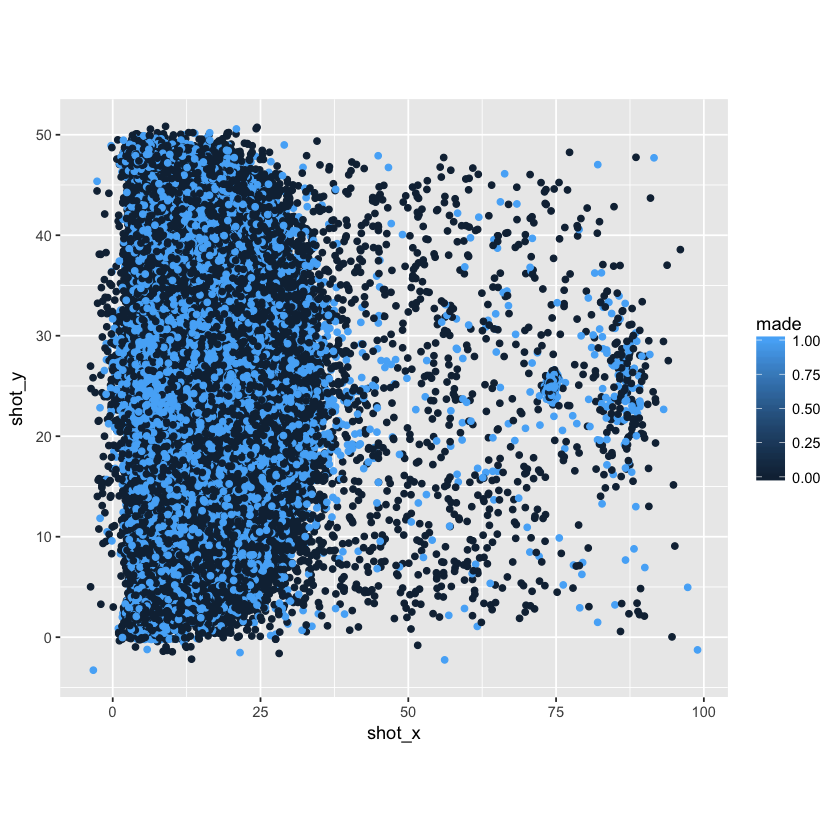

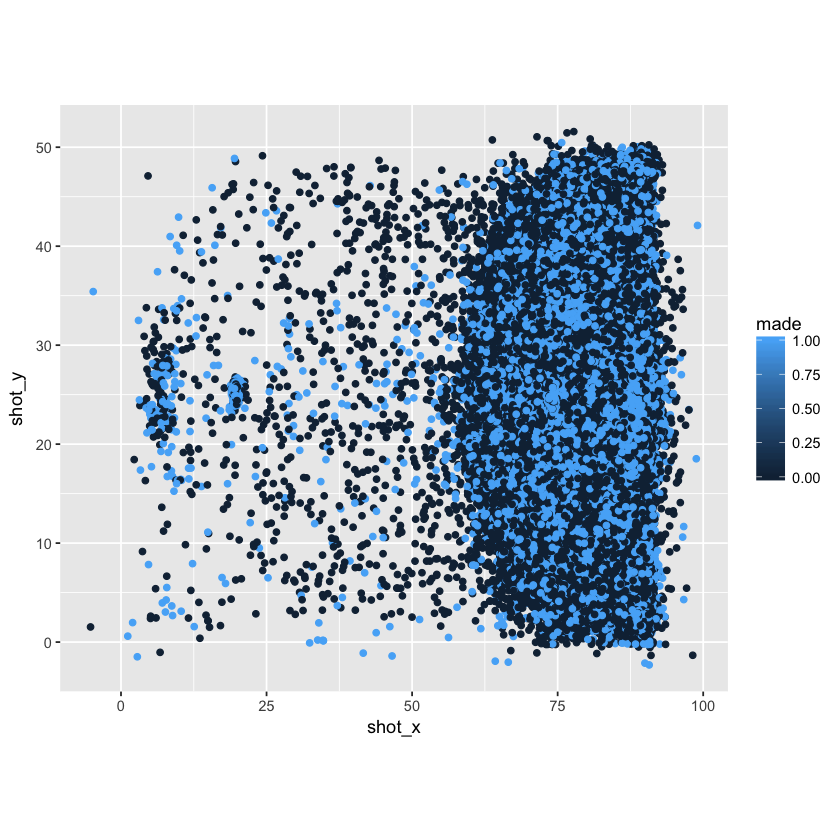

In [172]:
nba_l <- filter(nba, offense_basket == "L")
nba_r <- filter(nba, offense_basket == "R")

ggplot(nba_l, aes(x=shot_x, y=shot_y)) +
         geom_point(aes(colour = made)) +
         coord_fixed(ratio = 1.7)

ggplot(nba_r, aes(x=shot_x, y=shot_y)) +
         geom_point(aes(colour = made)) +
         coord_fixed(ratio = 1.7)

In [173]:
mean(nba$shot_x)

[1] 47.00584

### Midcourt of an NBA court is 47 feet from the baseline, and the mean shot_x coordinate is 47, so this indicates the x coordinates represent the sideline length, and the y coordinates represent the baseline length.  There is appears to be an usually high number of made shots beyond halfcourt for both plots.  Perhaps these entries were miscoded?  

### Next, adjust x/y coordinates for shot locations in order to analyze all shots together and graph on one plot:

In [175]:
nba_radj <- filter(nba, offense_basket == "R") %>% mutate(shot_x = 94 - shot_x, shot_y = 50 - shot_y)
nba1 <- rbind(nba_l, nba_radj)

### According to the below calculations, over 56% of shots taken from beyond half court are made.  Something appears to miscoded with that data, so it will be excluded it in later steps.

In [178]:
long_rg <- filter(nba1, shot_x > 47) 

#calculate % of shots beyone half court
sum(long_rg$made)
length(long_rg$made)
sum(long_rg$made) / length(long_rg$made) 

[1] 2476

[1] 4373

[1] 0.5662017

### In the next block of code, NA shot clock values are changed to -1 (which will be used to filter out Free Throws).  A number of new columns were then added to the data set:  1) Shot Type (1, 2, or 3), which is based on shot x/y coordinates (and shot clock for Free Throws * ), 2) Shot Distance, 3) a flag for Made/Missed, and 4) Shot Zone (based on x/y coordinates and Shot Type).   Additionally, a summary was generated that shows shot accuracy by Shot Type and Shot Zone.

### * A note on Free Throws:  Since Free Throws occur at the same area of the floor with the shot clock reset (or off), Free Throws were defined to be shots that were taken with shot coordinates of 19 < x < 20.3 and 23.7 < y < 26.3 that occurred at time 24 or -1(changed from NA) on the shot clock. 

In [183]:
nba1$shot_shot_clock[is.na(nba1$shot_shot_clock)] <- -1

nba2 <- nba1 %>% 
        #use shot coordinates to determine point value
        mutate(shot_type = ifelse(shot_y < 3 | shot_y > 47 | ((shot_x - 5.25)^2 + (shot_y - 25)^2) > (23.75^ 2),3, 
                               ifelse((shot_shot_clock == 24 | shot_shot_clock == -1) & 
                                   shot_x > 19 & shot_x < 20.3 & shot_y > 23.7 & shot_y < 26.3, 1,2))) %>% 
        # calculate shot distance
        mutate(shot_dist = sqrt((shot_x - 5.25 ) ^ 2 + (shot_y - 25 ) ^ 2)) %>% 
        # add flag for Made/Mised
        mutate(made_or_missed = ifelse(made == 0, "Missed", 
                              ifelse(made == 1, "Made","Undefined"))) %>% 
        # use point value and coordinates to determine shot zone
        mutate(shot_zone = ifelse(shot_type == 3, 
                              ifelse(shot_x > 47, "Beyond_Half_Court",
                                  ifelse(shot_y < 3 & shot_x < 14, "Left_Corner_3",
                                   ifelse(shot_y > 47 & shot_x < 14, "Right_Corner_3", "Top_or_Wing_3"))), 
                           ifelse(shot_type == 1, "FT", 
                           ifelse(shot_type == 2,
                           ifelse ((shot_x - 5.25) ^ 2 + (shot_y - 25) ^ 2 < 4 ^ 2 , "Restricted_Area",
                           ifelse(shot_y > 17 & shot_y < 33,  "Paint","Midrange_2")),"Undefined")))) %>%

        as.data.frame()                         


# generate shot summary
nba_pt_summary <- ddply(nba2, c("shot_type"), summarise, shots_made = sum(made), att = length(made),
                            pct = shots_made / att )
nba_pt_summary

nba_shot_summary <- ddply(nba2, c("shot_type", "shot_zone"), summarise, shots_made = sum(made), att = length(made),
                            pct = shots_made / att )
nba_shot_summary

shot_type,shots_made,att,pct
1,68841,91593,0.7515967
2,140315,286023,0.4905724
3,35718,96546,0.3699584


shot_type,shot_zone,shots_made,att,pct
1,FT,68841,91593,0.7515967
2,Midrange_2,31490,79490,0.3961505
2,Paint,60167,129538,0.4644737
2,Restricted_Area,48658,76995,0.6319631
3,Beyond_Half_Court,2476,4373,0.5662017
3,Left_Corner_3,4236,11027,0.3841480
3,Right_Corner_3,4862,12477,0.3896770
3,Top_or_Wing_3,24144,68669,0.3515997


### Aside from the above mentioned issue with the percentage of shots taken from beyond half court which are made, this data looks reasonable.  The percentage of shots made is 75.2% for Free Throws, 49.1% for 2 pointers and 37.0% for 3 pointers.  Additionally, the percentage is much higher in the Restricted Area, which is expected.  This data will be used as a baseline to compare against "wide open catch-and-shoot" situations.

### This plot shows all of the shots taken by the Sacramento Kings over two seasons. The x/y axis were trasnposed on the graph in order to display a view with the basket at the bottom.  Judging from the colors of the points on the graph relative to their area on the court, this confirms the shot zone was coded correctly:  

Warning message:
“Removed 191 rows containing missing values (geom_point).”

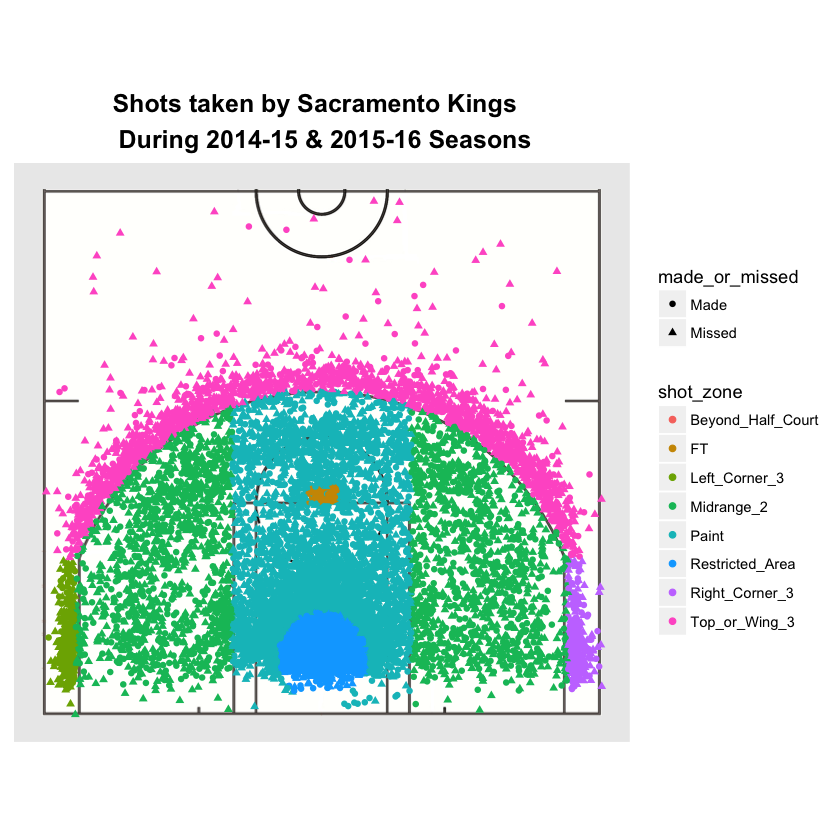

In [201]:
courtImg.URL <- "https://thedatagame.files.wordpress.com/2016/03/nba_court.jpg"
court <- rasterGrob(readJPEG(getURLContent(courtImg.URL)),width=unit(1,"npc"), height=unit(1,"npc"))

ggplot(nba2[nba2$team == 23,], aes(x=shot_y, y=shot_x)) + 
      annotation_custom(court, 0, 50, 0, 47) +
      geom_point(aes(colour = shot_zone, shape = made_or_missed)) +
      xlim(0, 50) +
      ylim(0, 47) +
      coord_fixed(ratio = 1) +
  ggtitle(paste("Shots taken by Sacramento Kings ", "\n", "During 2014-15 & 2015-16 Seasons")) +
  theme(line = element_blank(),
        plot.title = element_text(size = 15, lineheight = 1.2, face = "bold", hjust = 0.5),
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_blank())

# warning message is for shots taken behind the halfcourt line

### Due to the issue with shots taken from beyond half court, this data was removed.  As a result, the three point percentage actually decreased to 36.06%

In [443]:
# Filter out shots beyond half court

nba3 <- filter(nba2, shot_zone != "Beyond_Half_Court") %>% as.data.frame

nba_pt_summary2 <- ddply(nba3, c("shot_type"), summarise, shots_made = sum(made), att = length(made),
                            pct = shots_made / att )
nba_pt_summary2

nba_shot_summary2 <- ddply(nba3, c("shot_type", "shot_zone"), summarise, shots_made = sum(made), att = length(made),
                            pct = shots_made / att )
nba_shot_summary2

shot_type,shots_made,att,pct
1,68841,91593,0.7515967
2,140315,286023,0.4905724
3,33242,92173,0.3606479


shot_type,shot_zone,shots_made,att,pct
1,FT,68841,91593,0.7515967
2,Midrange_2,31490,79490,0.3961505
2,Paint,60167,129538,0.4644737
2,Restricted_Area,48658,76995,0.6319631
3,Left_Corner_3,4236,11027,0.3841480
3,Right_Corner_3,4862,12477,0.3896770
3,Top_or_Wing_3,24144,68669,0.3515997


### Next, the data was filtered to look at the shooting percentage on  "wide open catch-and-shoot" situations. These are instances where the nearest defender is greater than 4 feet away, and 0 or 1 dribbles are taken.  Ordinarily catch-and-shoot means 0 dribbles, but a shooter may sometimes take a rhythm dribble or use a quick dribble to reposition themselves (especially on a fast break or making a back-door cut) for an ideal shot.  

In [444]:
unguarded <- filter(nba3, dribbles < 2, ndd > 4)

unguarded_pt_summary <- ddply(unguarded, c("shot_type"), summarise, shots_made = sum(made), att = length(made),
                            pct = shots_made / att )
unguarded_pt_summary

unguarded_shot_summary <- ddply(unguarded, c("shot_type", "shot_zone"), summarise, shots_made = sum(made), att = length(made),
                            pct = shots_made / att )
unguarded_shot_summary

shot_type,shots_made,att,pct
1,39249,53636,0.7317660
2,33939,64586,0.5254854
3,24166,64276,0.3759724


shot_type,shot_zone,shots_made,att,pct
1,FT,39249,53636,0.7317660
2,Midrange_2,13097,30918,0.4236044
2,Paint,12891,24584,0.5243654
2,Restricted_Area,7951,9084,0.8752752
3,Left_Corner_3,3556,9009,0.3947164
3,Right_Corner_3,3991,9957,0.4008235
3,Top_or_Wing_3,16619,45310,0.3667844


In [445]:
cbind(unguarded_pt_summary$shot_type, round(unguarded_pt_summary$pct - nba_pt_summary2$pct,3))
cbind(unguarded_shot_summary$shot_zone, round(unguarded_shot_summary$pct - nba_shot_summary2$pct,3))

1,-0.020
2,0.035
3,0.015


FT,-0.02
Midrange_2,0.027
Paint,0.06
Restricted_Area,0.243
Left_Corner_3,0.011
Right_Corner_3,0.011
Top_or_Wing_3,0.015


### The above tables show that when compared to a baseline scenario, shooting percentage increases for all types of shots (except FT's) when the shot is taken in a wide open catch-and-shoot situation.  The shooting percentage increases by 3.5% for 2 pointers (24.3% in the Restricted Area!), and 1.5% for 3 pointers.  This increase emphasizes the value of a player that is able to successfully pass to a wide open shooter.  

### Next, to better understand the effect of open shooting, a GLM was briefly examined using a number of independent variable combinations to model a made or missed shot.  Amongst these combinations, the model with the lowest AIC value used independent variables of nearest defender, shot distance, number of dribbles and pass distance.  This GLM showed that ndd, shot distance and dribbles were all highly significant for this model.  In fact, this model shows that starting at an intercept of .2626 every increase of ndd by 1 foot increases the likelihood of a made field goal by 0.109, or almost 11%.  Obviously this model is also influenced by the other independent variables, but suffice to say that a wide-open shot is more desirable than a highly guarded shot.

In [388]:
# exclude FT's from GLM
mod_data <- filter(nba3, shot_type!=1)

In [399]:
logit_glm <- glm(made ~ ndd + shot_dist + dribbles + pass_distance, 
                 data = mod_data, family = "binomial"(link = 'logit'))
summary(logit_glm)


Call:
glm(formula = made ~ ndd + shot_dist + dribbles + pass_distance, 
    family = binomial(link = "logit"), data = mod_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4956  -1.0806  -0.8403   1.1644   2.1833  

Coefficients:
                Estimate Std. Error  z value Pr(>|z|)    
(Intercept)    0.2626750  0.0104851   25.052   <2e-16 ***
ndd            0.1092956  0.0015777   69.277   <2e-16 ***
shot_dist     -0.0620830  0.0005039 -123.196   <2e-16 ***
dribbles      -0.0227840  0.0010773  -21.148   <2e-16 ***
pass_distance -0.0003891  0.0004028   -0.966    0.334    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 461538  on 335217  degrees of freedom
Residual deviance: 444972  on 335213  degrees of freedom
  (42978 observations deleted due to missingness)
AIC: 444982

Number of Fisher Scoring iterations: 4


### For the next step, the data was filtered to look at field goals with 0 or 1 dribbles (catch-and-shoot), the nearest defender greater than 4 feet (wide open), and passes that traveled over 5 feet.   These parameters were chosen to determine a measure for how much field goal percentage increases when a player makes a pass of over 5 feet to a teammate in a wide open catch-and-shoot situation.  

In [303]:
nba_wo <- filter(nba2, dribbles < 2, ndd > 4, pass_distance > 5, shot_type != 1, shot_zone != "Beyond_Half_Court")
dim(nba_wo)

[1] 120097     22

### Merge the data from the other csv files based on defender id, passer id, and shooter id.

In [304]:
# drop unneeded columns
players[,5:8] <- NULL

# I might not use defense.... keep this here for now
defense <- players
col.d <- c("player_id","def.firstname","def.lastname","def.position")
colnames(defense) <- col.d

passer <- players
col.p <- c("player_id", "pass.firstname","pass.lastname","pass.position")
colnames(passer) <- col.p

shooter <- players
col.s <- c("player_id", "shoot.firstname","shoot.lastname","shoot.position")
colnames(shooter) <- col.s

nba_wo2 <- left_join(nba_wo, defense, by = c("defender" = "player_id")) %>%
               left_join(passer,  by = c("passer" = "player_id")) %>%
               left_join(shooter,  by = c("shooter" = "player_id")) %>%
               as.data.frame

sample_n(nba2,5)

,season,team,opponent,offense_basket,passer,pass_distance,shooter,poss_shot_clock,poss_game_clock,shot_x,⋯,shot_game_clock,dribbles,distance_travelled,defender,ndd,made,shot_type,shot_dist,made_or_missed,shot_zone
16712,2014,4,8,L,263220,14.16424,229569,9.00,615.87,7.41413,⋯,615.07,0,0.000000,253996,2.2000466,1,2,3.739617,Made,Restricted_Area
208438,2015,15,2,L,609790,27.32843,467271,14.33,208.32,8.60324,⋯,207.21,1,4.809837,462461,0.9295284,1,2,3.354458,Made,Restricted_Area
254193,2014,21,22,R,469085,19.14615,469089,16.13,646.03,4.98400,⋯,644.23,0,0.000000,253998,1.1003684,0,2,19.385175,Missed,Midrange_2
320315,2014,20,10,R,467471,17.27413,609790,14.49,657.86,25.38660,⋯,657.10,0,0.000000,332691,3.5804452,0,2,20.932733,Missed,Paint
208286,2015,7,9,L,NA,NA,510954,7.11,192.42,19.78930,⋯,192.00,0,0.000000,303807,6.1186846,1,1,14.560568,Made,FT


### There are 562 players in the filtered data set, however some of them have very low volume.  Players will less than 100 entries were dropped from the analysis. This leaves 301 players to be analyzed. 

In [305]:
nba_sum_for_drop <- ddply(nba_wo2, c("passer", "pass.lastname", "pass.firstname"), summarise, fg_made = sum(made), 
                 fg_att = length(made)) %>% arrange(fg_att)
dim(nba_sum_for_drop)
summary(nba_sum_for_drop$fg_att)

[1] 562   5

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    36.0   115.0   213.7   288.2  1724.0 

In [306]:
passers_to_drop  <- filter(nba_sum_for_drop, fg_att < 100) 
drop1 <- as.list(passers_to_drop$passer)

In [307]:
# this code would keep the players I want and drop others
nba_filt <- filter(nba_wo2, !(passer %in% drop1))
length(unique(nba_filt$passer))

[1] 301

### Next, a summary by shot_zone was created by player.  A calculation for 2 and 3 pointers was also added to the data, and a positional summary is created.  

In [308]:
nba_sum <- ddply(nba_filt, c("pass.position","pass.lastname", "pass.firstname", "shot_zone"), summarise, fg_made = sum(made), 
                 fg_att = length(made))

In [309]:
pos_sum_made = dcast(nba_sum, pass.position ~ shot_zone, value.var = "fg_made", fun.aggregate = sum, 
  na.rm = TRUE) %>% mutate(two_ptrs = Midrange_2 + Paint + Restricted_Area, three_ptrs = Top_or_Wing_3 +
                           Left_Corner_3 + Right_Corner_3, all_fgs = two_ptrs + three_ptrs) %>% as.data.frame

pos_sum_taken = dcast(nba_sum, pass.position ~ shot_zone, value.var = "fg_att", fun.aggregate = sum, 
  na.rm = TRUE) %>% mutate(two_ptrs = Midrange_2 + Paint + Restricted_Area, three_ptrs = Top_or_Wing_3 +
                           Left_Corner_3 + Right_Corner_3, all_fgs = two_ptrs + three_ptrs) %>% as.data.frame

# verifies the two data frame are identically arranged
identical(dim(pos_sum_made),dim(pos_sum_taken))
identical(dim(pos_sum_made$pass.position), dim(pos_sum_taken$pass.position))
identical(colnames(pos_sum_made), colnames(pos_sum_taken))

[1] TRUE

[1] TRUE

[1] TRUE

### Calculate shooting percentage by each position, shot_zone and type (2 or 3 pointer).  The summary by position is shown - this will be the baseline FG% used for each position to rank the players.

In [311]:
# divide the 2 data frames
pos_sum_pct <- round(pos_sum_made[,c(2:dim(pos_sum_made)[2])] / 
                    pos_sum_taken[,c(2:dim(pos_sum_taken)[2])],3)

# cbind to add position name back in
pos_sum <- cbind(pos_sum_pct, pos_sum_taken$pass.position )  

# rename column to eliminate the long name
colnames(pos_sum)[which(names(pos_sum) == "pos_sum_taken$pass.position")] <- "pass.position"

# rearrange the columns
pos_sum <- pos_sum %>%  select(pass.position, everything()) 

# change passer NA's to 0
pos_sum[,2:10][is.na(pos_sum[,2:10])] <- 0

pos_sum <- as.data.frame(pos_sum)

In [312]:
pos_sum

pass.position,Left_Corner_3,Midrange_2,Paint,Restricted_Area,Right_Corner_3,Top_or_Wing_3,two_ptrs,three_ptrs,all_fgs
Center,0.389,0.395,0.498,0.878,0.386,0.390,0.506,0.389,0.443
Forward,0.409,0.449,0.537,0.916,0.384,0.352,0.552,0.366,0.448
Forward-Center,0.400,0.436,0.540,0.873,0.428,0.377,0.548,0.388,0.454
Guard,0.404,0.429,0.506,0.897,0.393,0.367,0.511,0.376,0.444
Guard-Forward,0.399,0.426,0.542,0.910,0.410,0.371,0.528,0.382,0.451
Point Guard,0.380,0.424,0.490,0.892,0.398,0.360,0.501,0.369,0.437
Power Forward,0.440,0.385,0.579,0.876,0.448,0.374,0.544,0.395,0.456
Shooting Guard,0.455,0.437,0.525,0.910,0.375,0.364,0.521,0.380,0.456
Small Forward,0.415,0.437,0.554,0.895,0.408,0.373,0.536,0.384,0.459


### Next, similar calculations were made to obtain this summary at a player level:

In [313]:
pl_sum_made = dcast(nba_sum, pass.lastname + pass.firstname + pass.position ~ shot_zone, 
                    value.var = "fg_made", fun.aggregate = sum, na.rm = TRUE) %>% 
              mutate(two_ptrs = Midrange_2 + Paint + Restricted_Area, three_ptrs = Top_or_Wing_3 +
                           Left_Corner_3 + Right_Corner_3, all_fgs = two_ptrs + three_ptrs) %>% as.data.frame

pl_sum_taken = dcast(nba_sum, pass.lastname + pass.firstname + pass.position ~ shot_zone, 
                    value.var = "fg_att", fun.aggregate = sum, na.rm = TRUE) %>% 
              mutate(two_ptrs = Midrange_2 + Paint + Restricted_Area, three_ptrs = Top_or_Wing_3 +
                           Left_Corner_3 + Right_Corner_3, all_fgs = two_ptrs + three_ptrs) %>% as.data.frame

# verifies the two data frame are identically arranged
identical(dim(pl_sum_made),dim(pl_sum_taken))
identical(pl_sum_made$pass.lastname, pl_sum_taken$pass.lastname)
identical(pl_sum_made$pass.firstname, pl_sum_taken$pass.firstname)
identical(colnames(pl_sum_made), colnames(pl_sum_taken))

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

In [315]:
# divide the 2 data frames
pl_sum_pct <- round(pl_sum_made[,c(4:dim(pl_sum_made)[2])] / 
                    pl_sum_taken[,c(4:dim(pl_sum_taken)[2])],3)

# cbind to add player name back in
pl_sum <- cbind(pl_sum_pct, pl_sum_taken$pass.lastname, pl_sum_taken$pass.firstname, pl_sum_taken$pass.position )  

# rename columns to eliminate the long name
colnames(pl_sum)[which(names(pl_sum) == "pl_sum_taken$pass.position")] <- "pass.position"
colnames(pl_sum)[which(names(pl_sum) == "pl_sum_taken$pass.lastname")] <- "pass.lastname"
colnames(pl_sum)[which(names(pl_sum) == "pl_sum_taken$pass.firstname")] <- "pass.firstname"

# rearrange the columns
pl_sum <- pl_sum %>%  select(pass.lastname, pass.firstname, pass.position, everything()) 

# change passer NA's to 0
pl_sum[,4:12][is.na(pl_sum[,4:12])] <- 0

pl_sum <- as.data.frame(pl_sum)

### Rename columns (for table display)

In [317]:
pos_sum2 <- pos_sum

colnames(pos_sum2) <- c('position','lg_avg_Left_Corner_3',
  'lg_avg_Midrange_2', 'lg_avg_Paint', 'lg_avg_Restricted_Area', 'lg_avg_Right_Corner_3',
  'lg_avg_Top_or_Wing_3', 'lg_avg_two_ptrs', 'lg_avg_three_ptrs', 'lg_avg_all_fgs')

### Join the player and positional tables to calculate the summary of shooting % vs baseline (league avg at position).

In [318]:
# inner join to bring in positional data
sum_vs_avg <- inner_join(pl_sum, pos_sum2, by= c("pass.position" ="position"))

# compute the summary vs the positional average
sum_vs_avg <- mutate( sum_vs_avg,  vs_lg_avg_all_fgs = all_fgs - lg_avg_all_fgs,
                    vs_lg_avg_two = two_ptrs - lg_avg_two_ptrs,
                    vs_lg_avg_three = three_ptrs - lg_avg_three_ptrs,
                    #vs_lg_avg_Beyond_Half_Court = Beyond_Half_Court - lg_avg_Beyond_Half_Ct,
                    vs_lg_avg_Left_Corner_3 = Left_Corner_3 - lg_avg_Left_Corner_3,
                    vs_lg_avg_Midrange_2 = Midrange_2 - lg_avg_Midrange_2,
                    vs_lg_avg_Paint = Paint - lg_avg_Paint,
                    vs_lg_avg_Restricted_Area = Restricted_Area - lg_avg_Restricted_Area,
                    vs_lg_avg_Right_Corner_3 = Right_Corner_3 - lg_avg_Right_Corner_3,
                    vs_lg_avg_Top_or_Wing_3 = Top_or_Wing_3 - lg_avg_Top_or_Wing_3)

# cbind to bring in the fg percentage for all shots
sum_vs_avg <- cbind(sum_vs_avg, pl_sum_taken$all_fgs)

# change column name to shorter name
colnames(sum_vs_avg)[which(names(sum_vs_avg) == "pl_sum_taken$all_fgs")] <- "num_of_fg_attempts"

head(sum_vs_avg)


pass.lastname,pass.firstname,pass.position,Left_Corner_3,Midrange_2,Paint,Restricted_Area,Right_Corner_3,Top_or_Wing_3,two_ptrs,⋯,vs_lg_avg_all_fgs,vs_lg_avg_two,vs_lg_avg_three,vs_lg_avg_Left_Corner_3,vs_lg_avg_Midrange_2,vs_lg_avg_Paint,vs_lg_avg_Restricted_Area,vs_lg_avg_Right_Corner_3,vs_lg_avg_Top_or_Wing_3,num_of_fg_attempts
Acy,Quincy,Power Forward,0.667,0.395,0.545,0.857,0.667,0.362,0.493,⋯,-0.006,-0.051,0.001,0.227,0.010,-0.034,-0.019,0.219,-0.012,120
Adams,Steven,Center,0.500,0.440,0.571,1.000,0.250,0.411,0.545,⋯,0.013,0.039,0.011,0.111,0.045,0.073,0.122,-0.136,0.021,114
Afflalo,Arron,Guard-Forward,0.390,0.405,0.464,0.917,0.333,0.330,0.470,⋯,-0.048,-0.058,-0.043,-0.009,-0.021,-0.078,0.007,-0.077,-0.041,549
Aldridge,LaMarcus,Forward-Center,0.300,0.340,0.562,0.750,0.533,0.317,0.452,⋯,-0.075,-0.096,-0.031,-0.100,-0.096,0.022,-0.123,0.105,-0.060,401
Allen,Lavoy,Forward-Center,0.000,0.520,0.500,1.000,0.250,0.400,0.578,⋯,-0.016,0.030,-0.023,-0.400,0.084,-0.040,0.127,-0.178,0.023,130
Allen,Ray,Shooting Guard,0.636,0.394,0.842,1.000,0.577,0.441,0.635,⋯,0.097,0.114,0.120,0.181,-0.043,0.317,0.090,0.202,0.077,159


### Create boxplot, display by position

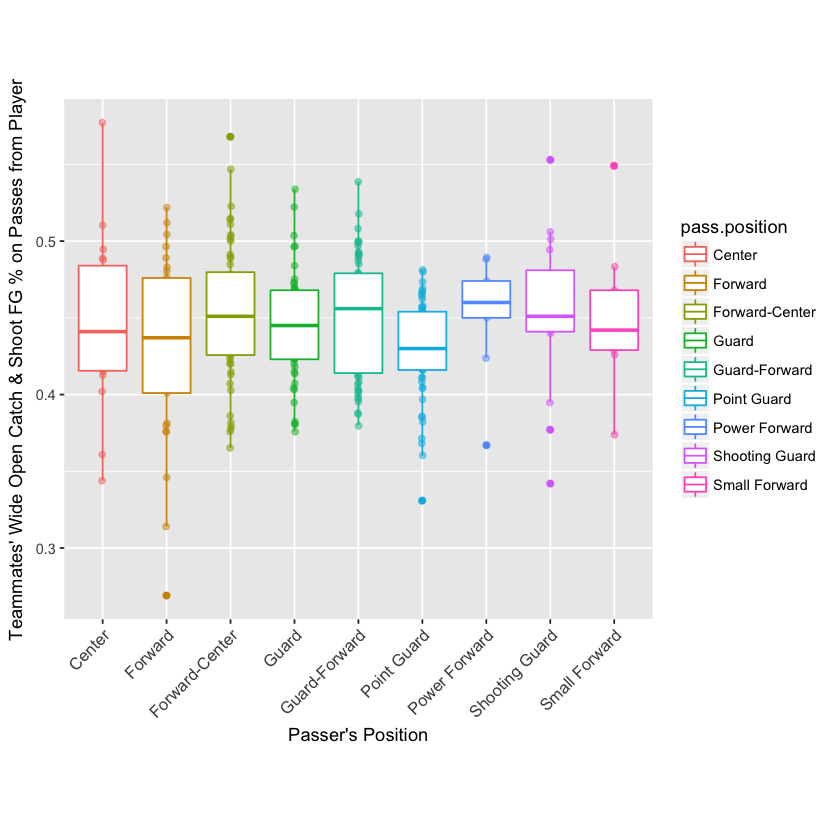

In [461]:
bp <- ggplot(sum_vs_avg, aes(x=pass.position , y=all_fgs)) 
bp + 
  geom_jitter(aes(color = pass.position, x = pass.position), 
              position = position_jitter(width = .01), alpha = 0.5) +
  geom_boxplot(aes(color = pass.position)) +
  xlab("Passer's Position") + ylab("Teammates' Wide Open Catch & Shoot FG % on Passes from Player") +
  coord_fixed(ratio = 24) +
  theme(axis.text.x=element_text(size=10,angle=45, hjust=1))

### The above boxplot shows the "T-WO-CAS-FG% on PFP", based on the passer's position.  Surprisingly, while Point Guards are usully regarded as good passers, there are a number of Point Guards with low teammates' shooting percentage on wide open shots.  The position of Forward-Center shows quite a few players with high rankings.  This could be due to the fact that the Forward-Center draws a lot of attention on interior double-teams and is adept at finding an open shooter with a high shooting percentage. Another surprise is highest value on the plot - Center DeAndre Jordan, who is primarily known for his rebounding and blocking abilitlies.  Apparently DeAndre is also the league's best when it comes to teammates' FG% on wide open catch-and-shoot shots from him. 

### The next section compiles the neccessary data for the players comparison to positional average, and creates a function to generate tables that can be easily read and understood:

In [320]:
pl_avg_summary <- select(sum_vs_avg, pass.lastname, pass.firstname, pass.position, 
                  num_of_fg_attempts, all_fgs, vs_lg_avg_all_fgs, vs_lg_avg_two, vs_lg_avg_three )

In [493]:
calc <- function(x) {
    filter(pl_avg_summary, pass.position == x, num_of_fg_attempts   > 100) %>% 
               arrange(desc(vs_lg_avg_all_fgs )) %>% plyr::rename(c("pass.lastname" = "Passer Last Name", 
                          "pass.firstname" = "Passer First Name", "pass.position" = "Position",
                          "num_of_fg_attempts" = "# of Passes > 5ft. from Player that led to Wide Open 
Catch & Shoot FG Attempts",
                          "all_fgs" = "Teammates' Wide Open Catch & Shoot FG % on Passes from Player", 
        "vs_lg_avg_all_fgs" = "Teammates' Wide Open Catch & Shoot FG % on Passes from Player - compared to 
Positional League Avg.",
        "vs_lg_avg_two" = "Teammates' Wide Open Catch & Shoot 2 pt FG % on Passes from Player - compared to 
Positional League Avg.",
        "vs_lg_avg_three" = "Teammates' Wide Open Catch & Shoot 3 pt FG % on Passes from Player - compared to 
Positional League Avg."))
 }

# change formatting to percentage
cleanup <- function(y) { 
    y[,5] <- scales::percent(y[,5])
    y[,6] <- scales::percent(y[,6])
    y[,7] <- scales::percent(y[,7])
    y[,8] <- scales::percent(y[,8])
    
    return(y)
}    

unique(sum_vs_avg$pass.position)

[1] Power Forward  Center         Guard-Forward  Forward-Center Shooting Guard
[6] Small Forward  Forward        Point Guard    Guard         
9 Levels: Center Forward Forward-Center Guard Guard-Forward ... Small Forward

In [503]:
# create table for each position by running the above function
pf_table <- calc(unique(sum_vs_avg$pass.position)[1]) %>% cleanup()
c_table <- calc(unique(sum_vs_avg$pass.position)[2]) %>% cleanup()
gf_table <- calc(unique(sum_vs_avg$pass.position)[3]) %>% cleanup()
fc_table <- calc(unique(sum_vs_avg$pass.position)[4]) %>% cleanup()
sg_table <- calc(unique(sum_vs_avg$pass.position)[5]) %>% cleanup()
sf_table <- calc(unique(sum_vs_avg$pass.position)[6]) %>% cleanup()
f_table <- calc(unique(sum_vs_avg$pass.position)[7]) %>% cleanup()
pg_table <- calc(unique(sum_vs_avg$pass.position)[8]) %>% cleanup()
g_table <- calc(unique(sum_vs_avg$pass.position)[9]) %>% cleanup()

#write.csv(pf_table, file = "pf_table.csv")
#write.csv(c_table, file = "c_table.csv")
#write.csv(gf_table, file = "gf_table.csv")
#write.csv(fc_table, file = "fc_table.csv")
#write.csv(sg_table, file = "sg_table.csv")
#write.csv(sf_table, file = "sf_table.csv")
#write.csv(f_table, file = "f_table.csv")
#write.csv(pg_table, file = "pg_table.csv")
#write.csv(g_table, file = "g_table.csv")


## Section II: Player Summary Tables

## Note: user-friendly versions of below tables are included as HTML files in the repository.  They may need to be downloaded and viewed in a browser to display properly.

### Below are tables that show the Top 5 players at each position based on “T-WO-CAS-FG% on PFP” (column 5)  

In [495]:
paste('Displayed below are the top 5 players at', unique(pf_table$Position), 'out of', dim(pf_table)[1], 
      'with at least 100 passes of 5 feet or more that lead to a wide open catch-and-shoot FG attempt.          
Ranking determined by Percentage Shooting on Wide Open shots received from player.')
head(pf_table, 5)

[1] "Displayed below are the top 5 players at Power Forward out of 9 with at least 100 passes of 5 feet or more that lead to a wide open catch-and-shoot FG attempt.          \nRanking determined by Percentage Shooting on Wide Open shots received from player."

Passer Last Name,Passer First Name,Position,# of Passes > 5ft. from Player that led to Wide Open Catch & Shoot FG Attempts,Teammates' Wide Open Catch & Shoot FG % on Passes from Player,Teammates' Wide Open Catch & Shoot FG % on Passes from Player - compared to Positional League Avg.,Teammates' Wide Open Catch & Shoot 2 pt FG % on Passes from Player - compared to Positional League Avg.,Teammates' Wide Open Catch & Shoot 3 pt FG % on Passes from Player - compared to Positional League Avg.
Faried,Kenneth,Power Forward,182,48.9%,3.3%,9.8%,0.5%
Scott,Mike,Power Forward,172,48.8%,3.2%,6.9%,2.3%
Kelly,Ryan,Power Forward,190,47.4%,1.8%,-6.9%,7.8%
West,David,Power Forward,448,46.7%,1.1%,4.7%,-1.7%
Morris,Marcus,Power Forward,239,46.0%,0.4%,-1.1%,-1.0%


In [496]:
paste('Displayed below are the top 5 players at', unique(c_table$Position), 'out of', dim(c_table)[1], 
      'with at least 100 passes of 5 feet or more that lead to a wide open catch-and-shoot FG attempt.          
Ranking determined by Percentage Shooting on Wide Open shots received from player.')
head(c_table, 5)

[1] "Displayed below are the top 5 players at Center out of 19 with at least 100 passes of 5 feet or more that lead to a wide open catch-and-shoot FG attempt.          \nRanking determined by Percentage Shooting on Wide Open shots received from player."

Passer Last Name,Passer First Name,Position,# of Passes > 5ft. from Player that led to Wide Open Catch & Shoot FG Attempts,Teammates' Wide Open Catch & Shoot FG % on Passes from Player,Teammates' Wide Open Catch & Shoot FG % on Passes from Player - compared to Positional League Avg.,Teammates' Wide Open Catch & Shoot 2 pt FG % on Passes from Player - compared to Positional League Avg.,Teammates' Wide Open Catch & Shoot 3 pt FG % on Passes from Player - compared to Positional League Avg.
Jordan,DeAndre,Center,111,57.7%,13.4%,11.5%,13.9%
Perkins,Kendrick,Center,102,51.0%,6.7%,7.9%,4.0%
Mozgov,Timofey,Center,105,49.5%,5.2%,2.7%,7.8%
Olynyk,Kelly,Center,223,48.9%,4.6%,8.7%,-0.7%
Splitter,Tiago,Center,127,48.8%,4.5%,2.6%,5.7%


In [497]:
paste('Displayed below are the top 5 players at', unique(gf_table$Position), 'out of', dim(gf_table)[1], 
      'with at least 100 passes of 5 feet or more that lead to a wide open catch-and-shoot FG attempt.          
Ranking determined by Percentage Shooting on Wide Open shots received from player.')
head(gf_table, 5)

[1] "Displayed below are the top 5 players at Guard-Forward out of 57 with at least 100 passes of 5 feet or more that lead to a wide open catch-and-shoot FG attempt.          \nRanking determined by Percentage Shooting on Wide Open shots received from player."

Passer Last Name,Passer First Name,Position,# of Passes > 5ft. from Player that led to Wide Open Catch & Shoot FG Attempts,Teammates' Wide Open Catch & Shoot FG % on Passes from Player,Teammates' Wide Open Catch & Shoot FG % on Passes from Player - compared to Positional League Avg.,Teammates' Wide Open Catch & Shoot 2 pt FG % on Passes from Player - compared to Positional League Avg.,Teammates' Wide Open Catch & Shoot 3 pt FG % on Passes from Player - compared to Positional League Avg.
Thompson,Klay,Guard-Forward,345,53.9%,8.8%,7.3%,9.1%
Carter,Vince,Guard-Forward,272,51.8%,6.7%,10.5%,-2.2%
Webster,Martell,Guard-Forward,124,50.8%,5.7%,0.5%,8.7%
Antetokounmpo,Giannis,Guard-Forward,364,50.0%,4.9%,4.6%,3.8%
Ginobili,Manu,Guard-Forward,532,50.0%,4.9%,11.3%,1.6%


In [498]:
paste('Displayed below are the top 5 players at', unique(fc_table$Position), 'out of', dim(fc_table)[1], 
      'with at least 100 passes of 5 feet or more that lead to a wide open catch-and-shoot FG attempt.          
Ranking determined by Percentage Shooting on Wide Open shots received from player.')
head(fc_table, 5)

[1] "Displayed below are the top 5 players at Forward-Center out of 56 with at least 100 passes of 5 feet or more that lead to a wide open catch-and-shoot FG attempt.          \nRanking determined by Percentage Shooting on Wide Open shots received from player."

Passer Last Name,Passer First Name,Position,# of Passes > 5ft. from Player that led to Wide Open Catch & Shoot FG Attempts,Teammates' Wide Open Catch & Shoot FG % on Passes from Player,Teammates' Wide Open Catch & Shoot FG % on Passes from Player - compared to Positional League Avg.,Teammates' Wide Open Catch & Shoot 2 pt FG % on Passes from Player - compared to Positional League Avg.,Teammates' Wide Open Catch & Shoot 3 pt FG % on Passes from Player - compared to Positional League Avg.
Davis,Anthony,Forward-Center,222,56.8%,11.4%,6.6%,14.9%
Henson,John,Forward-Center,137,54.7%,9.3%,5.8%,9.7%
Johnson,Amir,Forward-Center,176,52.3%,6.9%,4.8%,5.1%
Duncan,Tim,Forward-Center,309,51.5%,6.1%,9.8%,1.2%
Garnett,Kevin,Forward-Center,138,51.4%,6.0%,9.4%,0.6%


In [499]:
paste('Displayed below are the top 5 players at', unique(sg_table$Position), 'out of', dim(sg_table)[1], 
      'with at least 100 passes of 5 feet or more that lead to a wide open catch-and-shoot FG attempt.          
Ranking determined by Percentage Shooting on Wide Open shots received from player.')
head(sg_table, 5)

[1] "Displayed below are the top 5 players at Shooting Guard out of 15 with at least 100 passes of 5 feet or more that lead to a wide open catch-and-shoot FG attempt.          \nRanking determined by Percentage Shooting on Wide Open shots received from player."

Passer Last Name,Passer First Name,Position,# of Passes > 5ft. from Player that led to Wide Open Catch & Shoot FG Attempts,Teammates' Wide Open Catch & Shoot FG % on Passes from Player,Teammates' Wide Open Catch & Shoot FG % on Passes from Player - compared to Positional League Avg.,Teammates' Wide Open Catch & Shoot 2 pt FG % on Passes from Player - compared to Positional League Avg.,Teammates' Wide Open Catch & Shoot 3 pt FG % on Passes from Player - compared to Positional League Avg.
Allen,Ray,Shooting Guard,159,55.3%,9.7%,11.4%,12.0%
McLemore,Ben,Shooting Guard,231,50.6%,5.0%,3.5%,1.4%
Beal,Bradley,Shooting Guard,503,50.1%,4.5%,0.6%,7.1%
Caldwell-Pope,Kentavious,Shooting Guard,168,49.4%,3.8%,6.9%,2.0%
Gordon,Eric,Shooting Guard,470,46.8%,1.2%,0.9%,-0.8%


In [500]:
paste('Displayed below are the top 5 players at', unique(sf_table$Position), 'out of', dim(sf_table)[1], 
      'with at least 100 passes of 5 feet or more that lead to a wide open catch-and-shoot FG attempt.          
Ranking determined by Percentage Shooting on Wide Open shots received from player.')
head(sf_table, 5)

[1] "Displayed below are the top 5 players at Small Forward out of 9 with at least 100 passes of 5 feet or more that lead to a wide open catch-and-shoot FG attempt.          \nRanking determined by Percentage Shooting on Wide Open shots received from player."

Passer Last Name,Passer First Name,Position,# of Passes > 5ft. from Player that led to Wide Open Catch & Shoot FG Attempts,Teammates' Wide Open Catch & Shoot FG % on Passes from Player,Teammates' Wide Open Catch & Shoot FG % on Passes from Player - compared to Positional League Avg.,Teammates' Wide Open Catch & Shoot 2 pt FG % on Passes from Player - compared to Positional League Avg.,Teammates' Wide Open Catch & Shoot 3 pt FG % on Passes from Player - compared to Positional League Avg.
Barnes,Matt,Small Forward,237,54.9%,9.0%,8.0%,5.6%
Hill,Solomon,Small Forward,232,48.3%,2.4%,1.2%,3.5%
Green,Draymond,Small Forward,419,46.8%,0.9%,4.7%,1.9%
Casspi,Omri,Small Forward,199,46.2%,0.3%,-0.4%,1.6%
Jefferson,Richard,Small Forward,242,44.2%,-1.7%,-1.7%,-3.0%


In [501]:
paste('Displayed below are the top 5 players at', unique(pg_table$Position), 'out of', dim(pg_table)[1], 
      'with at least 100 passes of 5 feet or more that lead to a wide open catch-and-shoot FG attempt.          
Ranking determined by Percentage Shooting on Wide Open shots received from player.')
head(pg_table, 5)

[1] "Displayed below are the top 5 players at Point Guard out of 53 with at least 100 passes of 5 feet or more that lead to a wide open catch-and-shoot FG attempt.          \nRanking determined by Percentage Shooting on Wide Open shots received from player."

Passer Last Name,Passer First Name,Position,# of Passes > 5ft. from Player that led to Wide Open Catch & Shoot FG Attempts,Teammates' Wide Open Catch & Shoot FG % on Passes from Player,Teammates' Wide Open Catch & Shoot FG % on Passes from Player - compared to Positional League Avg.,Teammates' Wide Open Catch & Shoot 2 pt FG % on Passes from Player - compared to Positional League Avg.,Teammates' Wide Open Catch & Shoot 3 pt FG % on Passes from Player - compared to Positional League Avg.
Marshall,Kendall,Point Guard,501,48.1%,4.4%,3.4%,4.7%
Rondo,Rajon,Point Guard,929,48.0%,4.3%,6.7%,2.1%
Holiday,Jrue,Point Guard,560,47.3%,3.6%,4.9%,1.6%
Lowry,Kyle,Point Guard,904,46.9%,3.2%,5.1%,2.0%
Mack,Shelvin,Point Guard,526,46.8%,3.1%,4.5%,2.1%


In [502]:
paste('Displayed below are the top 5 players at', unique(g_table$Position), 'out of', dim(g_table)[1], 
      'with at least 100 passes of 5 feet or more that lead to a wide open catch-and-shoot FG attempt.          
Ranking determined by Percentage Shooting on Wide Open shots received from player.')
head(g_table, 5)

[1] "Displayed below are the top 5 players at Guard out of 52 with at least 100 passes of 5 feet or more that lead to a wide open catch-and-shoot FG attempt.          \nRanking determined by Percentage Shooting on Wide Open shots received from player."

Passer Last Name,Passer First Name,Position,# of Passes > 5ft. from Player that led to Wide Open Catch & Shoot FG Attempts,Teammates' Wide Open Catch & Shoot FG % on Passes from Player,Teammates' Wide Open Catch & Shoot FG % on Passes from Player - compared to Positional League Avg.,Teammates' Wide Open Catch & Shoot 2 pt FG % on Passes from Player - compared to Positional League Avg.,Teammates' Wide Open Catch & Shoot 3 pt FG % on Passes from Player - compared to Positional League Avg.
McCollum,C.J.,Guard,116,53.4%,9.0%,12.1%,6.5%
Galloway,Langston,Guard,182,52.2%,7.8%,2.6%,11.6%
Douglas,Toney,Guard,127,50.4%,6.0%,1.3%,10.8%
Felton,Raymond,Guard,543,49.7%,5.3%,6.1%,6.4%
Miller,Andre,Guard,448,49.6%,5.2%,4.3%,5.2%


## Section III:  Shot Charts

### For the final part of this project, two functions were created to generate graphs based on the above data.  The only input required to generate these graphs is the passer's first and last name.  These graphs show “T-WO-CAS-FG% on PFP” in two places -  the chart title summarizes the percentage on 2/3 point shots, and the plot shows the percentage based on the shot zone (left corner 3, restricted area, etc.).  The first graph displays “T-WO-CAS-FG% on PFP”, and the second graph shows the “T-WO-CAS-FG% on PFP” comparison to the positional league average for each shot zone. 

In [484]:
#############################
# first graph “T-WO-CAS-FG% on PFP” by shot zone

graph_player <- function(a,b){

# get shot set for selected player
shot_set <- filter(nba_filt, !shot_zone %in% c("FT", "Beyond_Half_Court"), pass.firstname == a,
                   pass.lastname == b)
# summarise shot data
library(plyr)
shot <- ddply(shot_set, .(shot_zone), summarize, 
        SHOTS_ATTEMPTED = length(made),
        SHOTS_MADE = sum(as.numeric(as.character(made))))
     
# calculate shot zone accuracy and add zone accuracy labels
shot$SHOT_ACCURACY <- (shot$SHOTS_MADE / shot$SHOTS_ATTEMPTED)
shot$SHOT_ACCURACY_LAB <- paste(as.character(round(100 * shot$SHOT_ACCURACY, 1)), "%", sep="")

# gets positional average data
pos_zone <- filter(pos_sum, 
                   pass.position == unique(shot_set$pass.position)[1]) %>% melt(id.vars = "pass.position") %>%
                   plyr::rename(c("variable" = "shot_zone", "value" = "lg_avg")) %>%
                   filter(!shot_zone %in% c("FT", "Beyond_Half_Court")) %>% mutate(ms_x = c(7,21,15,7,7,31,32,33,35),
                   ms_y = c(2,25,25,25,48,25,27,27,27))

# gets player summary data
player_ds <- filter(pl_avg_summary, pass.firstname == a, pass.lastname == b)

pl_all_fgs <- scales::percent(as.numeric (player_ds[5]))
pl_all_vs_avg <- scales::percent(as.numeric (player_ds[6]))

pl_2_total <- scales::percent(pos_zone[7,3] + as.numeric (player_ds[7]))
pl_3_total <- scales::percent(pos_zone[8,3] + as.numeric (player_ds[8]))    

# join with league average and gets in coordinates for graph
shot <- left_join(shot, pos_zone[,c("shot_zone","lg_avg","ms_x","ms_y")], by = "shot_zone" ) %>% 
         as.data.frame() 

#create plot    
ggplot(shot, aes(x=ms_y, y=ms_x)) +
scale_color_brewer(palette = "Dark2", type="qual", name = "Shot Accuracy by location on floor") +
    annotation_custom(court, 0, 50, 0, 47) +
    geom_point(aes(col = shot_zone), size = 7) +
    geom_text(aes(col = shot_zone, label = SHOT_ACCURACY_LAB), vjust = -1.2, size = 6) +
   guides(colour = guide_legend(order = 1)) +
    xlim(0, 50) +
    ylim(0, 47) +
    coord_fixed(ratio = .7) +
    ggtitle(paste("Teammates Wide Open Catch & Shoot FG% From Passes > 5 ft. by Player\n", a," ", b, " - ",
                  pos_zone$pass.position, 
                  "\n", "T-WO-CAS-FG% on PFP - all FG's: ",pl_all_fgs,
                  "\n", "T-WO-CAS-FG% on PFP - 2 pointers: ",pl_2_total,
                  "\n", "T-WO-CAS-FG% on PFP - 3 pointers: ",pl_3_total,sep = "")) +
    theme(line = element_blank(),
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_blank(),
        legend.position = c(0.77, 0.74),   
        legend.title = element_text(size=11),
        legend.text=element_text(size = 12),
        plot.title = element_text(size = 13, lineheight = 1.2, face = "bold", hjust = 0.5))
}

### Function to create graph to compare against league avg at position

In [485]:
#############################
# second graph “T-WO-CAS-FG% on PFP” by shot zone vs. positional league avg.

graph_player_vs_lg <- function(a,b){

# get shot set for selected player
shot_set <- filter(nba_filt, !shot_zone %in% c("FT", "Beyond_Half_Court"), pass.firstname == a,
                   pass.lastname == b)

# summarise shot data
library(plyr)
shot <- ddply(shot_set, .(shot_zone), summarize, 
        SHOTS_ATTEMPTED = length(made),
        SHOTS_MADE = sum(as.numeric(as.character(made))))   

# calculate shot zone accuracy and add zone accuracy labels
shot$SHOT_ACCURACY <- (shot$SHOTS_MADE / shot$SHOTS_ATTEMPTED)
shot$SHOT_ACCURACY_LAB <- paste(as.character(round(100 * shot$SHOT_ACCURACY, 1)), "%", sep="")

# gets league average data for player's position
pos_zone <- filter(pos_sum, 
                   pass.position == unique(shot_set$pass.position)[1]) %>% melt(id.vars = "pass.position") %>%
                   plyr::rename(c("variable" = "shot_zone", "value" = "lg_avg")) %>%
                   filter(!shot_zone %in% c("FT", "Beyond_Half_Court")) %>% mutate(ms_x = c(7,21,15,7,7,31,32,33,35),
                   ms_y = c(2,25,25,25,48,25,27,27,27))

# gets data on specific player
player_ds <- filter(pl_avg_summary, pass.firstname == a, pass.lastname == b)

# extracts player data    
pl_all_fgs <- scales::percent(as.numeric (player_ds[5]))
pl_all_vs_avg <- scales::percent(as.numeric (player_ds[6]))

pl_all_2vs_avg <- scales::percent(as.numeric (player_ds[7]))
pl_all_3vs_avg <- scales::percent(as.numeric (player_ds[8]))

pl_2_total <- scales::percent(pos_zone[7,3] + as.numeric (player_ds[7]))
pl_3_total <- scales::percent(pos_zone[8,3] + as.numeric (player_ds[8]))
      
# join with league average and compute difference
shot <- left_join(shot, pos_zone[,c("shot_zone","lg_avg","ms_x","ms_y")], by = "shot_zone" ) %>% 
         mutate(VS_LG_AVG = SHOT_ACCURACY - lg_avg,
                VS_LG_AVG_LAB = paste(as.character(round(100 * VS_LG_AVG, 1)), "%", sep="")) %>%
         as.data.frame() 

# sets default color scale
clr_bound <- max(abs(shot$VS_LG_AVG))
grad_lim <- .20

# changes the color scale if there is a large value on shot chart    
if(clr_bound > grad_lim) {grad_lim = round(clr_bound +.05 ,1) }
grad_limits <- c(-grad_lim, grad_lim)

myPalette <- colorRampPalette(rev(brewer.pal(11, "RdBu")))

# plots data
ggplot(shot, aes(x=ms_y, y=ms_x)) +
    scale_colour_gradientn(colours = myPalette(100), limits=grad_limits, labels = percent, 
                           name = "Comparison to Leage\nAverage at position") +
    annotation_custom(court, 0, 50, 0, 47) +
    geom_point(aes(col = VS_LG_AVG), size = 7) +
    geom_text(aes(col = VS_LG_AVG, label = VS_LG_AVG_LAB), vjust = -1.2, size = 6) +
   guides(alpha = FALSE, size = FALSE) +
    xlim(0, 50) +
    ylim(0, 47) +
    coord_fixed(ratio = .7) +
    ggtitle(paste("Teammates Wide Open Catch & Shoot FG% From Passes > 5 ft. by Player\n", a," ", b, " - ",
                  pos_zone$pass.position, 
                  "\n", "T-WO-CAS-FG% on PFP - all FG's - compared to Positional League Avg: ", pl_all_vs_avg,
                  "\n", "T-WO-CAS-FG% on PFP - 2 pointers - compared to Positional Leauge Avg: ", pl_all_2vs_avg,
                  "\n", "T-WO-CAS-FG% on PFP - 3 pointers - compared to Positional League Avg: ", pl_all_3vs_avg,sep = "")) +
    theme(line = element_blank(),
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_blank(),
        legend.position = c(0.81, 0.75),   
        legend.title = element_text(size=11),
        legend.text=element_text(size = 12),
        plot.title = element_text(size = 13, lineheight = 1.2, face = "bold", hjust = 0.5))
}    

Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”

Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”

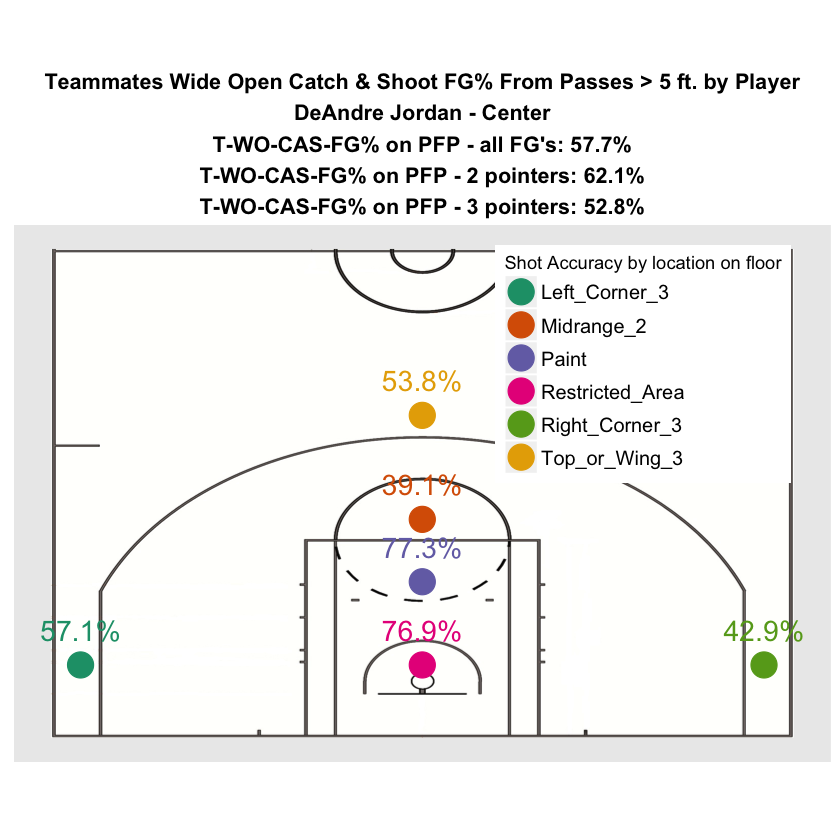

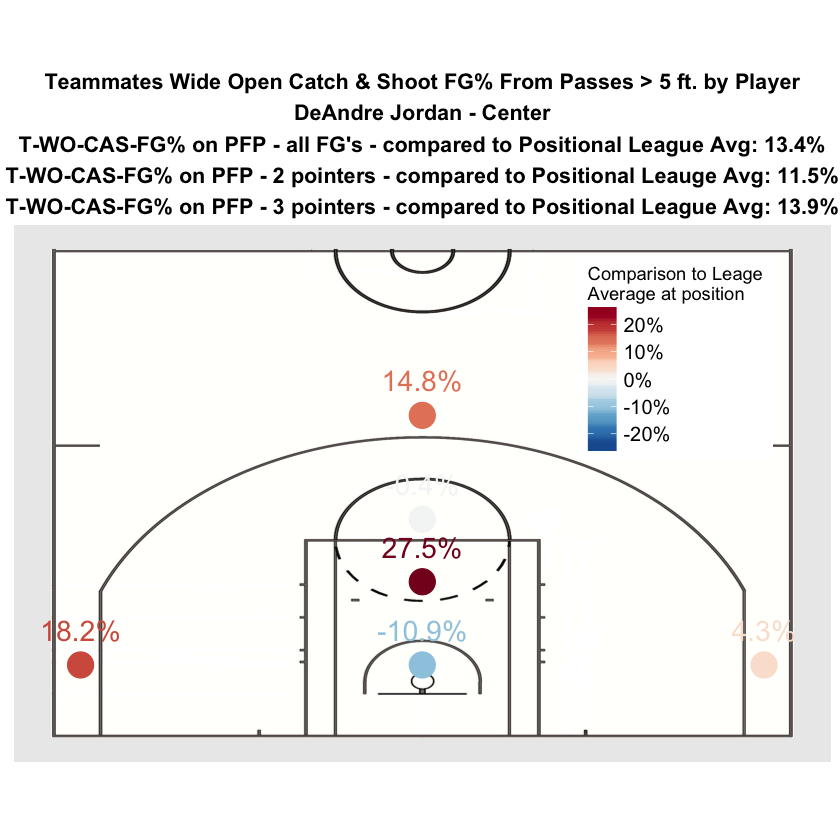

In [486]:
# input passer name to generate graphs:
pass_f_name <- "DeAndre"
pass_l_name <- "Jordan"

graph_player(pass_f_name,pass_l_name)
graph_player_vs_lg(pass_f_name,pass_l_name)

### The above graphs on DeAndre Jordan show that when he passes to a wide open teammate in the paint, these shooters have a 27.5% higher shooting percentage than when other Centers pass to a wide open teammate in the paint.  Passes from DeAndre to wide-open shooters also result in a much higher three point FG % (13.9% for all 3's, 18.2% from the left corner, 4.3% from the right corner and 14.8% from the top of the key / wing).  While it certainly helps to play alongside great shooting teammates, they need to get the ball in wide open situations to be effective. 

Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”

Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”

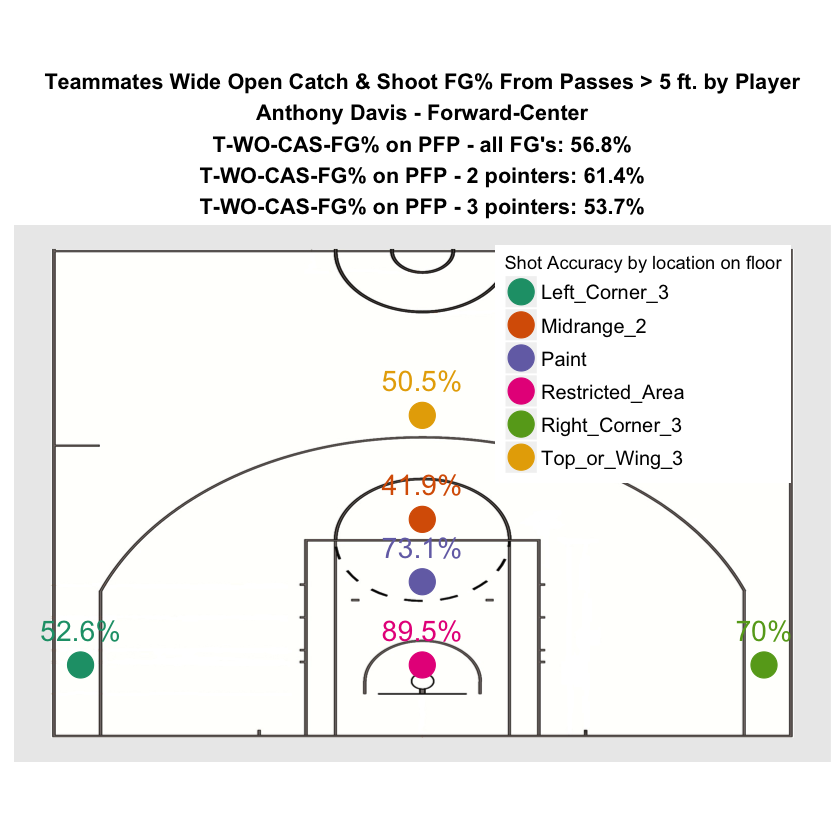

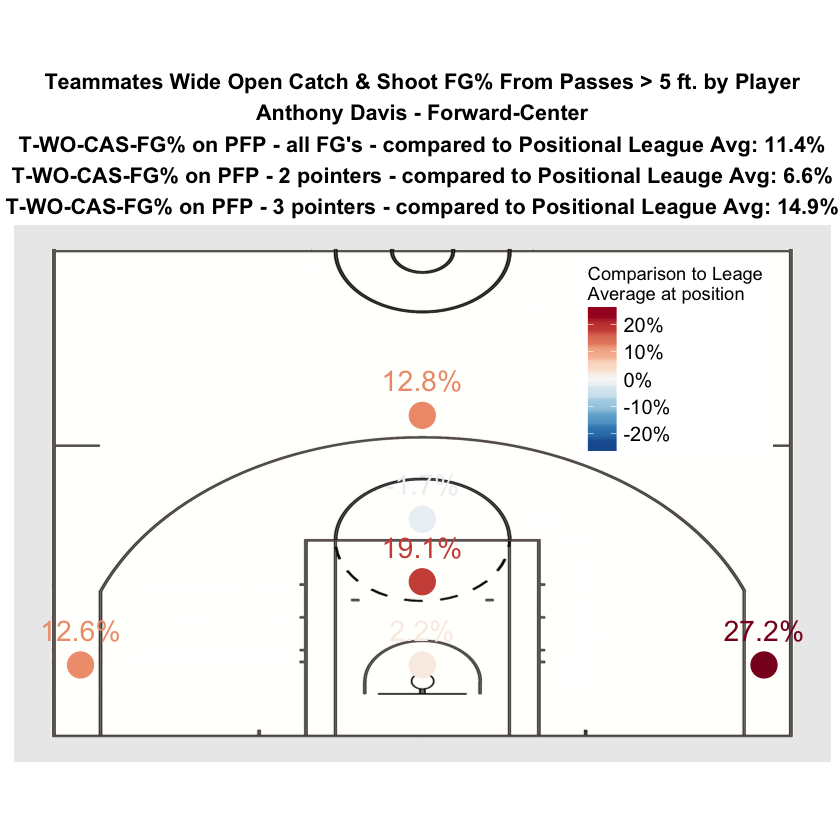

In [489]:
# input passer name to generate graphs:
pass_f_name <- "Anthony"
pass_l_name <- "Davis"

graph_player(pass_f_name,pass_l_name)
graph_player_vs_lg(pass_f_name,pass_l_name)

### The above graphs on Anthony Davis, classified as a Forward-Center, shows how much better his teammates' shooting % on wide open shots passed from him is compared to the average for Forward-Centers.  A player as dominant and skilled as Davis certainly attracts extra attention, which opens up the floor a lot more for his shooters to hit wide open shots. 

Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”

Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”

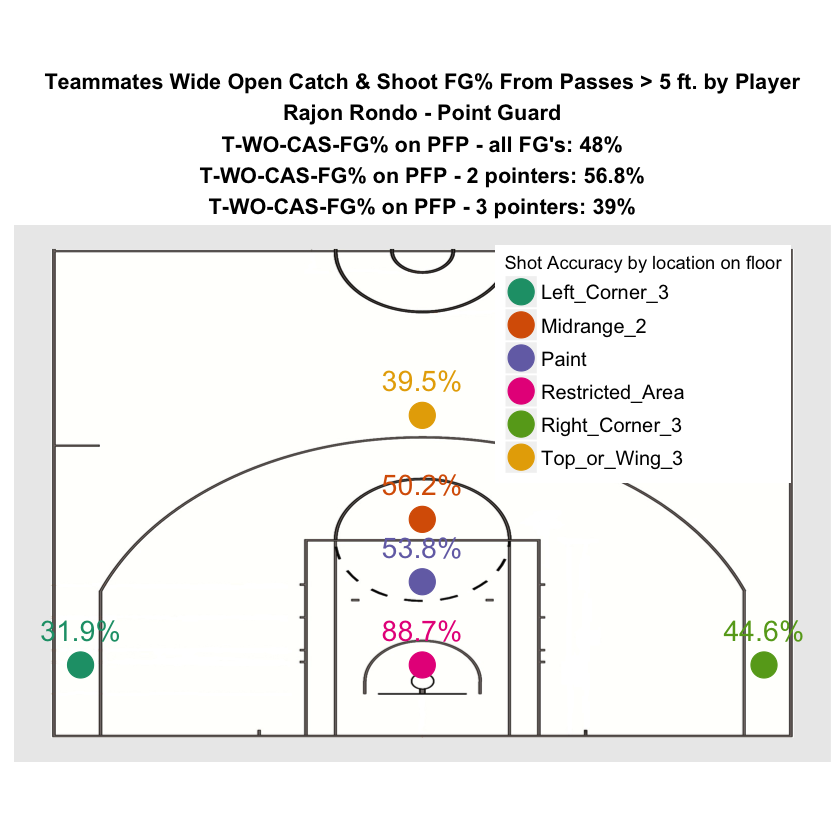

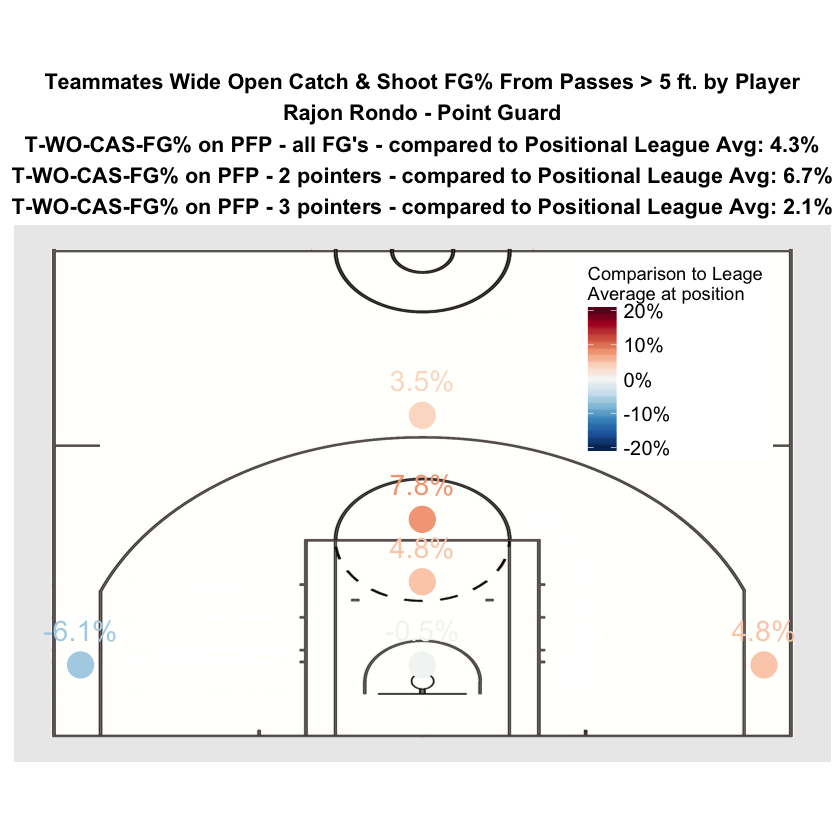

In [491]:
# input passer name to generate graphs:
pass_f_name <- "Rajon"
pass_l_name <- "Rondo"

graph_player(pass_f_name,pass_l_name)
graph_player_vs_lg(pass_f_name,pass_l_name)

### Rajon Rondo has one of the "T-WO-CAS-FG% on PFP" for Point Guards.  When he finds a wide open teammate for a catch and shoot midrange 2 pointer, his teammates' FG % is 50.2%, 7.8% above the league average for Point Guards.

### The potential next steps for the analysis could include adjusting for the player being passed to (obviously Steph Curry should have a higher FG % on wide open catch-and-shoot situations than say, Anderson Varejao).  Additionally, some teams are just better shooters than others, whether it is team because of the roster composition, the pace they play, the usage of shooting coaches, analytics, etc.   Therefore, some teams will be better shooters than others, so an adjustment could be made for specific teams in order to get a better sense of the passer's added value in the "T-WO-CAS-FG% on PFP" statistic.  Finally, some of the positions have very few players (Power Forward and Small Forward each only had 9 players with 100 passes that qualified for this measure), so certain positions could be clustered together and analyzed.  